In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [ ]:
# Download data
df = yf.download("AAPL", start="2015-01-01", end="2024-01-01")
company = 'Apple'
stock_data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Create a new dataframe with relevant features
data = stock_data
data.index = pd.to_datetime(data.index)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714725,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716957,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049522,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973555,237458000
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


In [ ]:
# Prepare the data for RF
feature_columns = ['Open', 'High', 'Low', 'Volume']  # Example features
target_column = 'Close'

# Create feature and target arrays
features = data[feature_columns]
target = data[target_column]

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.9)
train_features = features.iloc[:train_size]
test_features = features.iloc[train_size:]
train_target = target.iloc[:train_size]
test_target = target.iloc[train_size:]

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [ ]:
# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(train_features, train_target)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
rf_predictions = best_rf_model.predict(test_features)

# Evaluate the model
mse = mean_squared_error(test_target, rf_predictions)
mae = mean_absolute_error(test_target, rf_predictions)
rmse = math.sqrt(mse)

print('Best parameters found: ', grid_search.best_params_)
print('MSE: ' + str(mse))
print('MAE: ' + str(mae))
print('RMSE: ' + str(rmse))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSE: 51.74976780919269
MAE: 4.573334096496852
RMSE: 7.193731146574265


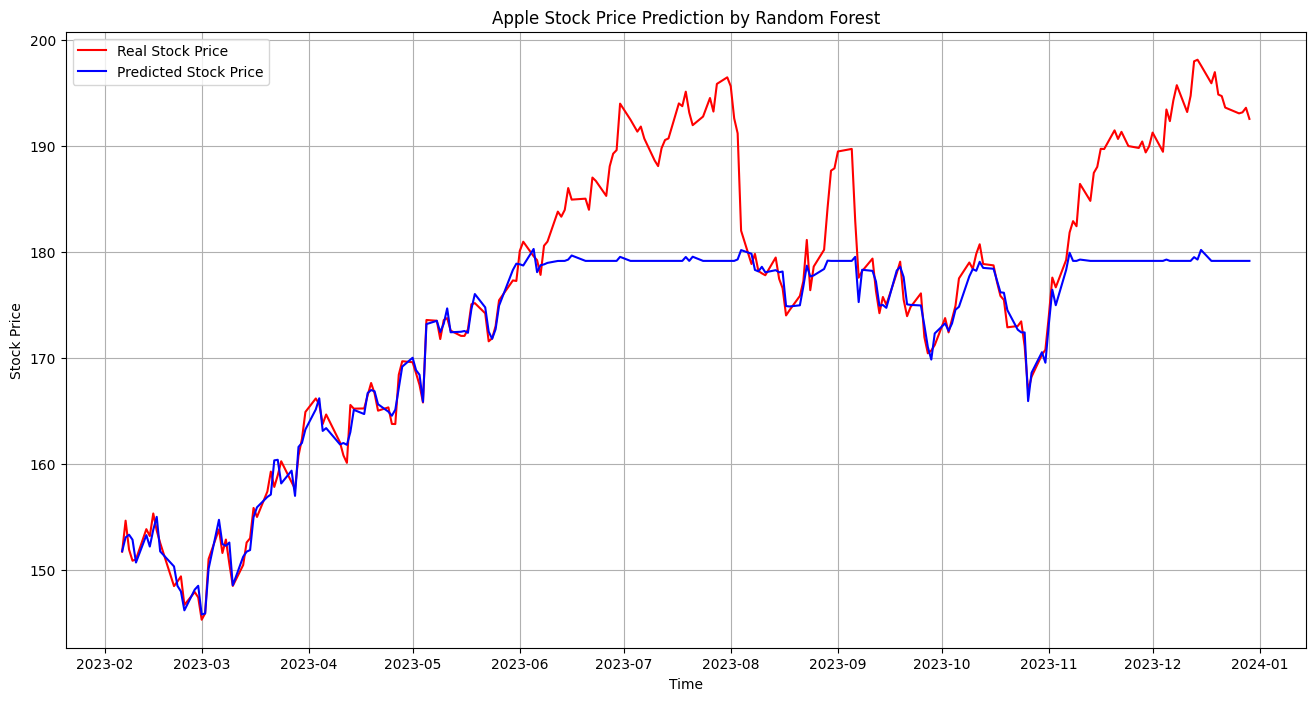

In [ ]:
# Plot results
plt.figure(figsize=(16,8))
plt.plot(data.index[-len(test_features):], test_target, color='red', label='Real Stock Price')
plt.plot(data.index[-len(test_features):], rf_predictions, color='blue', label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction by Random Forest')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('random_forest_prediction.pdf')
plt.show()

In [ ]:
#Train,Test data for GRU
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
train_data.shape


(2037, 6)

In [ ]:
test_data.shape

(227, 6)

In [ ]:
# GRU model
train = train_data.iloc[:, 0:1].values
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [ ]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
model = Sequential()
model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.20))
model.add(GRU(units = 50, return_sequences = True))
model.add(Dropout(0.25))
model.add(GRU(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units = 50))
model.add(Dropout(0.25))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0568
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0047
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0038
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0034
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0033
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0030
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0030
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0024
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0024
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0020


In [ ]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Close'], test_data['Close']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [ ]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

MSE: 21.044768629274596
MAE: 3.86645084330689
RMSE: 4.587457752314957


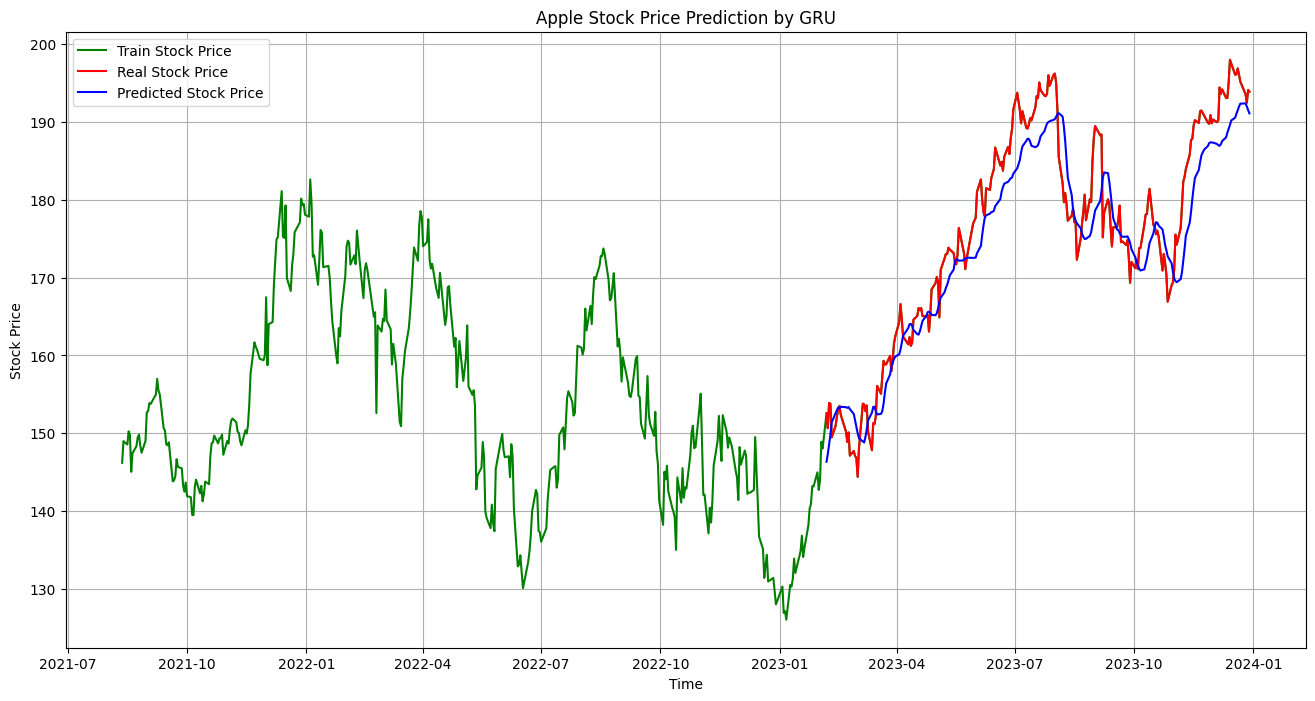

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction by GRU')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('gru_30.pdf')
plt.show()

In [ ]:
# Ensure predictions are aligned with test_data index
ran_pre = rf_predictions
gru_predictions = pd.Series(predicted_stock_price.flatten(), index=test_data.index)

# Compute ensemble predictions (simple average)
ensemble_predictions = (ran_pre + gru_predictions) / 2

# Create DataFrame
results_df = pd.DataFrame({
    'Date': test_data.index,
    'Real Stock Price': real_stock_price.flatten(),
    'Random Forest': ran_pre,
    'GRU Prediction': gru_predictions,
    'Ensemble Prediction': ensemble_predictions
})
results_df


,Date,Real Stock Price,Random Forest,GRU Prediction,Ensemble Prediction
Date,,,,,
2023-02-06,2023-02-06,152.570007,152.044801,146.321259,149.183030
2023-02-07,2023-02-07,150.639999,152.783599,147.326584,150.055092
2023-02-08,2023-02-08,153.880005,152.793199,148.564682,150.678940
2023-02-09,2023-02-09,153.779999,152.658398,149.824036,151.241217
2023-02-10,2023-02-10,149.460007,150.596201,151.402267,150.999234
...,...,...,...,...,...
2023-12-22,2023-12-22,195.179993,179.409797,192.370651,185.890224
2023-12-26,2023-12-26,193.610001,179.409797,192.404358,185.907077
2023-12-27,2023-12-27,192.490005,179.409797,192.019608,185.714702


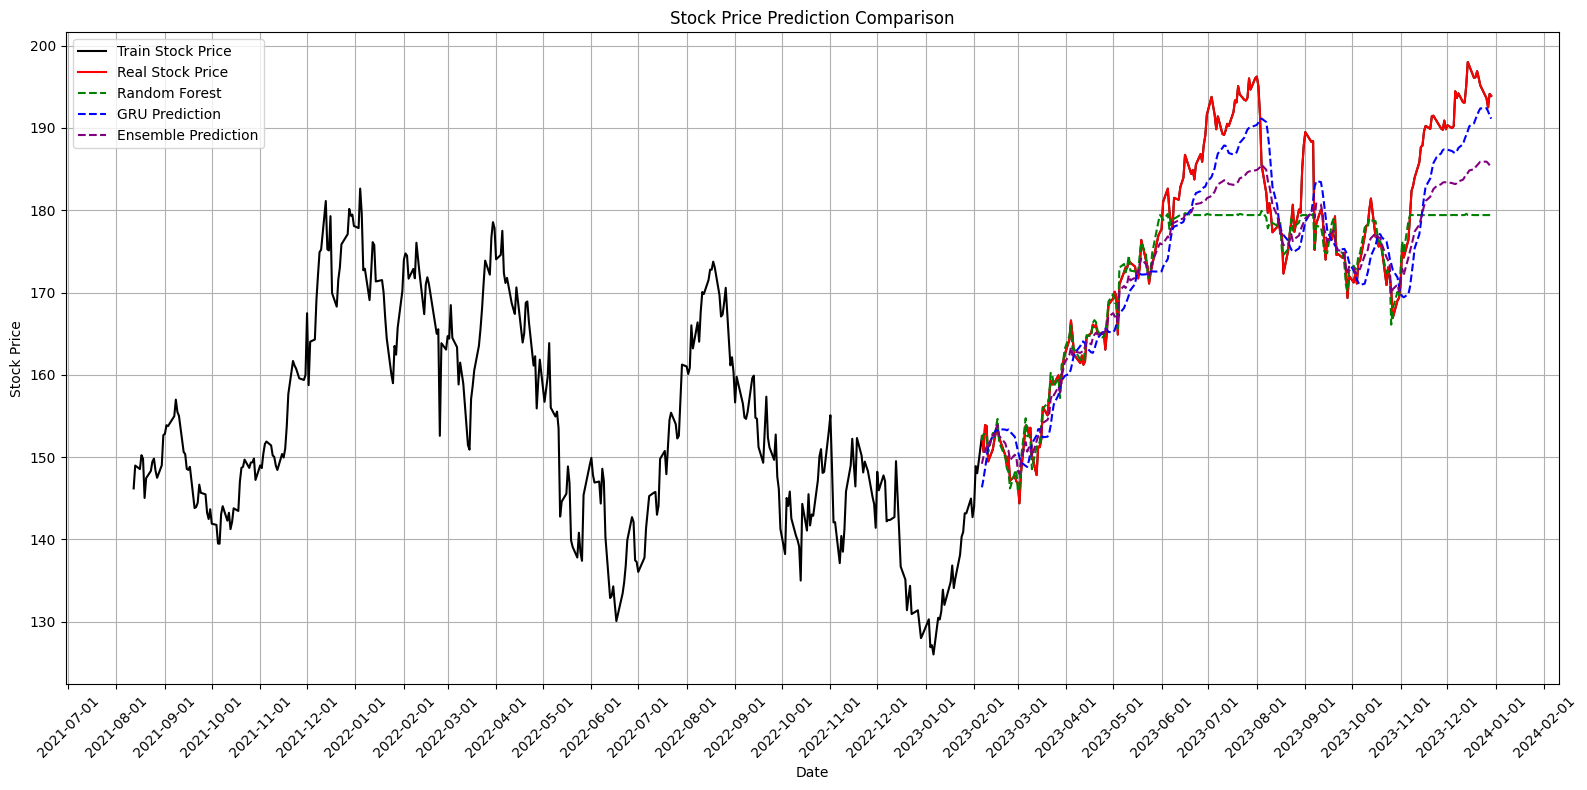

In [ ]:
# Set Date as index
results_df.set_index('Date', inplace=True)

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='black', label='Train Stock Price')
plt.plot(results_df.index, results_df['Real Stock Price'], color='red', label='Real Stock Price')
plt.plot(results_df.index, results_df['Random Forest'], color='green', linestyle='--', label='Random Forest')
plt.plot(results_df.index, results_df['GRU Prediction'], color='blue', linestyle='--', label='GRU Prediction')
plt.plot(results_df.index, results_df['Ensemble Prediction'], color='purple', linestyle='--', label='Ensemble Prediction')

# Formatting x-axis for dates
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ensemble_model_comparison.pdf')
plt.show()
